In [1]:
### Enter variables

In [115]:
# Input files
storage_shapefile = "temp.shp"
storage_id_field = "Wks_Num_tx"

# Output files
outputCSV = "Construction_Date.csv"

# Cloud cover
CLOUD_FILTER = 0 # Under 60%

# Thresholds
ndwiMaskVal = -0.1

In [100]:
### Import modules

In [93]:
import ee, geemap, folium, pandas, geopandas as gpd, json, datetime, altair as alt, csv, os
from IPython.display import Image
import ee.mapclient

# importing pandas as pd
import pandas as pd

In [94]:
### Declare functions

In [69]:
def filterImages(storage_geometry):
    # Load Landsat 5 & 7
    l5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")
    l7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
    # Merge Landsat 5 & 7
    l57merge = l5.merge(l7) 
    # Filter landsat collections by area, cloud cover and bands required for NDWI
    l57filter = (l57merge.filterBounds(storage_geometry)
              #.filterDate(start_date, end_date)
              .select(['B2','B5'])
              .map(lambda image: image.clip(storage_geometry).reproject(crs=utmZoneInfo)))
              #.filterMetadata('CLOUD_COVER', 'less_than', CLOUD_FILTER))
    # Add date
    l57filter.map(addDate)
    # Sort by date
    images = l57filter.sort('Date')
    return images

def clipimg(img):
    img.clip(storage_geometry)
    return img

def finddate(img):    
    date = ee.Date(img.get('system:time_start')).format("yyyy-MM-dd")
    print(date)
    
    return 
    
#NDVI calculation:
def areadate(img):
    area = img.gt(0).multiply(ee.Image.pixelArea()).divide(1000000).reduceRegion(ee.Reducer.sum(), storage_geometry, 30).get('NDWI');
    return img.set('area', area).set('date', img.get('system:time_start'));

def ndwi_func(i):
    ndwi = i.normalizedDifference (['B2', 'B5']).rename('NDWI')
    return i.addBands(ee.Image(ndwi))

def get_ndwi(i):
    print(i.get('NDWI'))
    ndwi = i.get('NDWI') 
    print(i.get('system:time_start'))
    date = i.get('system:time_start')
    return

def addDate(image):
    # parse date stored in 'system:index'
    date = ee.Date(image.get('system:index'))

    # format date, see http:#www.joda.org/joda-time/apidocs/org/joda/time/format/DateTimeFormat.html
    str = date.format('YYYY-mm-dd')

    return image.set({'Date': str})

def year_func(y):
    range = ee.Filter.calendarRange (y, y, 'year')
    mean = (l57ndwi
            .filter(range)
            .select('NDWI')
            .mean()
            .reduceRegion(ee.Reducer.mean(), storage_geometry, 30))
    return mean.set('year', y)

def test_api():
    dem = ee.Image('USGS/SRTMGL1_003')
    xy = ee.Geometry.Point([86.9250, 27.9881])
    elev = dem.sample(xy, 30).first().get('elevation').getInfo()
    print('Authentication active')
    
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

    #@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz
    
    # Display map
    #folium.Map.add_ee_layer = add_ee_layer

def get_landsat_col(aoi):    

    L5coll = (ee.ImageCollection('LANDSAT/LT05/C01/T1_SR')
        .filterBounds(aoi)        
        .filter(ee.Filter.lt('CLOUD_COVER', CLOUD_FILTER)))

    L7coll = (ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')
        .filter(ee.Filter.lt('CLOUD_COVER', CLOUD_FILTER))
        .filterBounds(aoi))

    L8coll = (ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
        .filter(ee.Filter.lt('CLOUD_COVER', CLOUD_FILTER))
        .filterBounds(geometry)
        .select(['B3', 'B2', 'B1']));
    
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))
        

def ee_array_to_df2(arr):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    #df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    #for band in list_of_bands:
    #    df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df
    
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df


def add_ndwi_bands(img):
    
    #green = img.select('B3').rename('green')
    #nir = img.select('B8')
    #swir2 = img.select('B12')
    #.updateMask(ndwi.gte(0.10))
    
    ### This example would create a binary raster that could then be used as a mask on other images
    ### We'll do it all in 1 step...
    #Create a Boolean land mask from the SWIR1 band; water is value 0, land is 1.
    #var landMask = img.select('B11').gt(100);

    ndwi = img.normalizedDifference(['B3','B8']).rename('ndwi')#['B3','B8']#.float()
    #ndwimasked = ndwi.updateMask(ndwi.gte(-0.1)).rename('ndwi')
    mndwi = img.normalizedDifference(['B3','B12']).rename('mndwi')
    #mndwimasked = mndwi.updateMask(mndwi.gte(0.1)).rename('mndwi')
    #ndwi = green.subtract(nir).divide(green.add(nir)).rename('ndwi')
    #mndwi = green.subtract(swir2).divide(green.add(swir2)).rename('mndwi')
    
    return img.addBands(ee.Image([ndwi, mndwi]))
    #return img.addBands(ee.Image([ndwimasked, mndwimasked]))


#Define cloud mask component functions
#Cloud Components
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


#Cloud Shadow Components
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))



#Final cloud shadow mask
def add_cld_shdw_mask(img):
    
    #Add Robs NDWI stuff
    img = img#.clip(AOI)#Clipping here doesn't really speed things up
    
    firstcrack = add_ndwi_bands(img)
    
    # Add cloud component bands.
    #img_cloud = add_cloud_bands(img)
    img_cloud = add_cloud_bands(firstcrack)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0).rename('cloudandshadow')
    #is_cld_shdw = is_cld_shdw.rename('cloudandshadow')
    
    #Rob thinks this is cutting out too much cloud....
    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw_FB = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20}))
        #.rename('cloudmasksimple'))

    is_cld_shdw_Buff = (is_cld_shdw.focalMax(BUFFERSMALL*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20}))
    
    is_cld_shdw_FB = is_cld_shdw_FB.rename('cloudandshadowfiltbuff')
    is_cld_shdw_Buff = is_cld_shdw_Buff.rename('cloudandshadowbuff')
    
    # Add the final cloud-shadow mask to the image.
    #return img_cloud_shadow.addBands(is_cld_shdw, is_cld_shdw_simple)
    return img_cloud_shadow.addBands(ee.Image([is_cld_shdw, is_cld_shdw_FB, is_cld_shdw_Buff]))



def calc_stats_from_layers(col):
    # Mosaic the image collection.
    img = col.mosaic()#.clip(AOI)
    
    #selfMask, I think, drops out Zeros, just like it you manually masked to keep values > 0

    # Subset layers and prepare them for display.
#     clouds = img.select('clouds').selfMask()
#     shadows = img.select('shadows').selfMask()
#     dark_pixels = img.select('dark_pixels').selfMask()
#     probability = img.select('probability')
#     cloudandshadow = img.select('cloudandshadow').selfMask()
#     cloudandshadowfandb = img.select('cloudandshadowfiltbuff').selfMask()
    cloudandshadowbuff = img.select('cloudandshadowbuff').selfMask()
#    cloud_transform = img.select('cloud_transform')
    ndwi = img.select('ndwi')
    ndwiMaskLayer = ndwi.gte(ndwiMaskVal).rename('ndwiMaskLayer')
    mndwi = img.select('mndwi')
    mndwiMaskLayer = mndwi.gte(mndwiMaskVal).rename('mndwiMaskLayer')
    
    #This would retain values of NDWI, not set them to 0/1
    ndwimasked = ndwi.updateMask(ndwiMaskLayer)#.rename('ndwi')
    mndwimasked = mndwi.updateMask(mndwiMaskLayer)#.rename('ndwi')
    
    #Need one complete raster for total area stats calc
    ndwiProj = ndwi.clip(aoi).reproject(crs=utmZoneInfo, scale=10)#Chosen 10 metres, , crsTransform='null'
    ndwiMaskedProj = ndwiMaskLayer.clip(aoi).reproject(crs=utmZoneInfo, scale=10)
    mndwiMaskedProj = mndwiMaskLayer.clip(aoi).reproject(crs=utmZoneInfo, scale=10)
    cloudandshadowbuffProj = cloudandshadowbuff.clip(aoi).reproject(crs=utmZoneInfo, scale=10)
    
    #This will now give each cell in the mask area 1 * pixel area
    #ndwiMaskLayer = ndwi.gte(ndwiMaskVal).multiply(ee.Image.pixelArea()).rename('ndwiMaskLayer')
    allStatsLayer = ndwiProj.gte(-50.0).multiply(ee.Image.pixelArea()).rename('allPixels')
    ndwiStatsLayer = ndwiMaskedProj.multiply(ee.Image.pixelArea()).rename('ndwiStatsLayer')
    mndwiStatsLayer = mndwiMaskedProj.multiply(ee.Image.pixelArea()).rename('mndwiStatsLayer')
    cloudStatsLayer = cloudandshadowbuffProj.multiply(ee.Image.pixelArea()).rename('cloudStatsLayer')
    #ndwimasked = ndwi.updateMask(ndwiMaskLayer)#.rename('ndwi')

        
    
    #DF to capture stats
    #storageStats = pandas.DataFrame(columns=['Site_Name','Total_Area','Water_Area','Cloud_Area'])#,'Cloud_Area'
    #Feature Group
    startStats = datetime.datetime.now()
    
    theCollection = ee.FeatureCollection(json_storages)
    
    allStats = allStatsLayer.reduceRegions(**{'reducer': ee.Reducer.sum(),'crs':utmZoneInfo, 'scale': 10,'collection': theCollection})
    ndwiStats = ndwiStatsLayer.reduceRegions(**{'reducer': ee.Reducer.sum(),'crs':utmZoneInfo, 'scale': 10,'collection': theCollection})
    mndwiStats = mndwiStatsLayer.reduceRegions(**{'reducer': ee.Reducer.sum(),'crs':utmZoneInfo, 'scale': 10,'collection': theCollection})
    cloudStats = cloudStatsLayer.reduceRegions(**{'reducer': ee.Reducer.sum(),'crs':utmZoneInfo, 'scale': 10,'collection': theCollection})

    
    endStats = datetime.datetime.now()
    statsDdiff = (endStats-startStats).total_seconds()

    #print("Zonal Stats took " + str(statsDdiff) + " seconds")
    #print(ndwiStats.getInfo()['features'][0]['properties'])

    
    return {'allAreas':allStats,'ndwiAreas':ndwiStats,'mndwiAreas':mndwiStats,'cloudAreas':cloudStats}

In [70]:
### Authenticate Earth Engine

In [71]:
yourUserName = "dechastelj" #"ellisr"
yourPassword = "Droneforce1"

In [72]:
os.environ['http_proxy'] = "http://" + yourUserName + ":" + yourPassword + "@web-prdproxy-usr.dmz:80"
os.environ['https_proxy'] = "http://" + yourUserName + ":" + yourPassword + "@web-prdproxy-usr.dmz:80"

In [73]:
# Test access then authenticate if fails
try:
    test_api()
except:    
    ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

Authentication active


In [74]:
### Load storage shapefile

In [116]:
# Load shapefile into geopandas
storage_shapes = gpd.read_file(storage_shapefile)

# Convert shapes into json
json_storages = json.loads(storage_shapes.to_json())

# Convert json into feature geometry
storage_geometry = ee.Geometry(ee.FeatureCollection(json_storages).geometry())

# Convert json into feature collection
storage_collection =  ee.FeatureCollection(json_storages)

# Set the zone info
utmZoneInfo = 'EPSG:28354' #z54S
#utmZoneInfo = 'EPSG:28355' #z55S

In [117]:
### Preview storage attributes and features

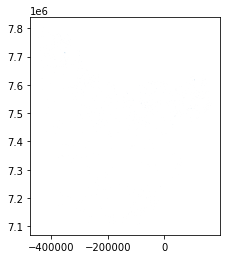

In [118]:
# Show attributes
#print(storage_collection.getInfo())

# Plot features
%matplotlib inline
storage_shapes.plot()

In [119]:
### Get a list of Storage IDs

In [120]:
# list the unique quality code values
worksSet = sorted(storage_shapes[storage_id_field].unique())
print(worksSet)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [121]:
### Build dictionary for results

In [122]:
storageStats = pandas.DataFrame(columns=[storage_id_field, 'date', 'total_pixels', 'ndwi_pixels', 'percent'])
print(storageStats)

Empty DataFrame
Columns: [Wks_Num_tx, date, total_pixels, ndwi_pixels, percent]
Index: []


In [123]:
### Make a cloud cover query

In [124]:
cloud_cover = 'CLOUD_COVER < ' + str(CLOUD_FILTER)

In [125]:
### Clip imagery to each storage

In [126]:
# For each storage
for x in worksSet:
    
    # Progress message
    print("Processing storage: {}".format(x))
  
    # Select the feature
    storage_selection = storage_collection.filter(ee.Filter.eq(storage_id_field, x))
    
    # Get the geometry
    storage_geometry = storage_selection.geometry()

    # Create list of images
    images = filterImages(storage_geometry)
    
    # Create a list of images
    imageSize = images.size().getInfo()    
    print(imageSize)
    
    # Add NDWI
    images.map(ndwi_func)
        
    # Sort by date
    #l57merge.sort('system:time_start')

    # Get the size of the collection
    #numElements = l57merge.size().getInfo()
    #print(numElements)
    
    # Create a list of sorted image dates
    #datelist = ee.List(l57merge.aggregate_array('system:time_start'))
    #datelist = datelist.distinct()
    
    #print(numElements)

    #df = pd.DataFrame(l57ndwi)
    #print(l57ndwi)
    
    # Mask NDWI
    #ndwiMaskLayer = l57ndwi.gte(ndwiMaskVal).rename('ndwiMaskLayer')
    #datedf = ee_array_to_df2(l57ndwi)
    
    #finddate(l57merge)
    #dates = ndwiMaskLayer.aggregate_array('system:time_start')
    #dates = dates.map(function(x){return ee.Date(x)})
    #print(dates)
        
    #for each image in the collection
    #for img in l57ndwi:
    #    print(img.name)
    
    # Create a list of years from 1986 to 2022
    #years = ee.List.sequence(1986,2022)
    
    # Calculating year wise NDVI.  Result is a list of dictionaries.
    #yearwise_ndvi = years.map(year_func).getInfo()
    #df = pd.DataFrame(yearwise_ndvi)
    
    # Select values over the threshold
    #const_date = df.loc[df['NDWI'] >= ndwiMaskVal]
    
    # Create a list of years
    #years_list = const_date['year']    
    #print(years_list)
    
    # Find the first year
    #firstyear = 9999
    #for index, row in const_date.iterrows():
    
        #year = row['year']
        #if year < firstyear:
            #firstyear = year

    # Print the first year
    #print("First wet year: " + str(int(firstyear)))
    
    # Add values to the storage stats
    #storageStats.loc[storageStats.shape[0]] = [x, firstyear]
    #storageStats = storageStats.append(df2, ignore_index = True)
    
# Print the storage stats
#print("Finished")
#print(storageStats)

Processing storage: 1


TypeError: Object of type int64 is not JSON serializable